# GPU Check

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
#from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from loss_functions.triplet_loss import TripletLoss
import math
import glob
from os import listdir
from os import walk
import PIL.Image as Image
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm 


In [2]:
DATA_PATH_TRAIN = '../../dataset/face_labeled_data/train'
DATA_PATH_VAL = '../../dataset/face_labeled_data/val'
DATA_PATH_TEST = '../../dataset/face_labeled_data/test'
BATCH_SIZE = 32
WORKERS = 8
epochs = 100
alpha = 0.5
learning_rate = 0.05

# simsiamPath = None
simsiamPath = "./model_simsiam_crop07/checkpoint_backbone_0100.pth.tar"

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

# Dataset

#### Define dataset, and dataloader

In [3]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_dataset(dir, class_to_idx):
    images = []
    targets = []
    for target in os.listdir(dir):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for filename in os.listdir(d):
            if is_image_file(filename):
                path = '{0}/{1}'.format(target, filename)
                item = (path, class_to_idx[target])
                images.append(item)
                targets.append(class_to_idx[target])

    return images, targets

class TripletImageLoader(Dataset):
    def __init__(self, root, choic_count = 2, transform=None, target_transform=None):
        classes, class_to_idx = find_classes(root)
        imgs, targets = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.choic_count = choic_count
        self.label_to_indices = {label: np.where(np.array(targets) == int(label))[0]
                                     for label in self.classes}
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        imgs = []
        targets = []
        path, target = self.imgs[index]
        random_choice = np.random.choice(list(self.label_to_indices[str(target)]), size=self.choic_count)
        for choice_index in random_choice:
            path, target = self.imgs[choice_index]
            img = Image.open(os.path.join(self.root, path)).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            imgs.append(img)
            targets.append(target)

        return imgs, targets

    def __len__(self):
        return len(self.imgs)

In [4]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset_train = TripletImageLoader(DATA_PATH_TRAIN, transform=trans)
dataset_val = TripletImageLoader(DATA_PATH_VAL, transform=trans)
dataset_test = TripletImageLoader(DATA_PATH_TEST, transform=trans)

train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print('class_to_idx ', len(dataset_train.class_to_idx))
print('val_loader ', len(dataset_train.class_to_idx))
print('test_loader ', len(dataset_train.class_to_idx))
dataset_train.__len__()


class_to_idx  176
val_loader  176
test_loader  176


17460

### Test Data loader

0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for int

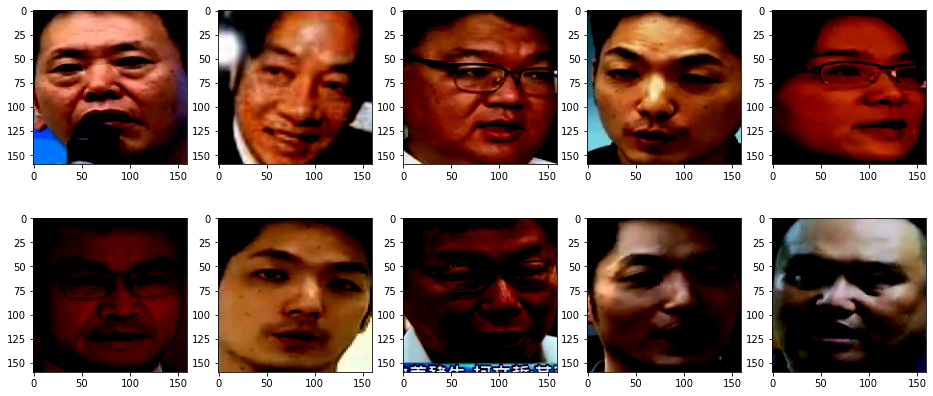

0it [00:03, ?it/s]

tensor([ 95, 145,  26, 133, 167, 160, 133,  98, 133, 169, 160,  42,  98, 137,
         24,  98, 133, 100, 173,  95, 153,  86, 132, 159, 100, 133,  92, 132,
        133,  98, 123, 100,  95, 145,  26, 133, 167, 160, 133,  98, 133, 169,
        160,  42,  98, 137,  24,  98, 133, 100, 173,  95, 153,  86, 132, 159,
        100, 133,  92, 132, 133,  98, 123, 100])
torch.Size([64])


In [5]:
dataset_debug = TripletImageLoader(DATA_PATH_TRAIN,choic_count = 2, transform=trans)
debug_loader = DataLoader(
    dataset_debug,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

for i_batch, image_batch in tqdm(enumerate(debug_loader)):
    x, y = torch.cat(image_batch[0], 0), torch.cat(image_batch[1], 0)
    ROW, COL = 2, 5
    f, ax = plt.subplots(ROW, COL, figsize=(16, 7))
    for i in range(ROW):
        for j in range(COL):
            img = x[i*COL+j]
            ax[i][j].imshow(img.permute(1, 2, 0))
    plt.show()
    break
print(y)
print(y.size())

# model

 ### define optimizer, scheduler

In [6]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

### fix model

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
backbone = InceptionResnetV1().to(device)

# 讀入simsiam的參數（預訓練)
if simsiamPath != None:
    backbone.load_state_dict(torch.load(simsiamPath)['state_dict'])
    set_parameter_requires_grad(backbone, True)

# projector
projector = nn.Sequential(
    nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
    nn.Linear(1024, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
    nn.Linear(1024, 512), nn.BatchNorm1d(512), L2_norm()
) 
projector.to(device)

# predictor
predictor = nn.Sequential(
    nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(),
    nn.Linear(256, len(dataset_train.class_to_idx)), nn.Softmax()
)
predictor.to(device)

backbone_optimizer = optim.Adam(backbone.parameters(), lr=learning_rate)
backbone_scheduler = MultiStepLR(backbone_optimizer, [5, 10])

projector_optimizer = optim.Adam(projector.parameters(), lr=learning_rate)
projector_scheduler = MultiStepLR(projector_optimizer, [5, 10])

predictor_optimizer = optim.Adam(predictor.parameters(), lr=learning_rate)
predictor_scheduler = MultiStepLR(predictor_optimizer, [5, 10])

#### Define loss and evaluation functions

In [9]:
tripletLoss_fn = TripletLoss(device)
crossEntropyLoss_fn = torch.nn.CrossEntropyLoss()

def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

metrics = {
    'acc': accuracy
}

#### Train model

In [10]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [11]:
def update_loss_hist(ax, train_loss, eval_loss,name):
    clear_output(wait=True)
    ax.plot(train_loss)
    ax.plot(eval_loss)
    #ax.set_ylim([0, 5])

    ax.set_title(name)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.legend(['train', 'val'], loc='center right')
def show_loss(train_loss, eval_loss,names, is_save):
    fig, axs = plt.subplots(len(train_loss), 1, figsize=(len(train_loss) * 7, 16))
    for i, (train, val, name) in enumerate(zip(train_loss, eval_loss, names)):
        update_loss_hist(axs[i], train, val, name)
    if (is_save):
        plt.savefig('TripletLoss_result.png')
    plt.show()

In [12]:
def pass_epoch(loader, mode = 'Train'):
    loss = 0
    loss_triplet = 0
    loss_cross = 0
#     for i_batch, image_batch in enumerate(loader):
    for i_batch, image_batch in tqdm(enumerate(loader)):
        x, y = torch.cat(image_batch[0], 0).to(device), torch.cat(image_batch[1], 0).to(device)
        if mode == 'Train':
            if simsiamPath != None:
                backbone.eval()
            else:
                backbone.train()
            projector.train()
            predictor.train()
        elif mode == 'Eval':
            backbone.eval()
            projector.eval()
            predictor.eval()
        else:
            print('error model mode!')
        x = backbone(x)
        y_feature = projector(x)
        y_pred = predictor(y_feature)
        
        loss_batch_triplet = tripletLoss_fn(y_feature, y)
        loss_batch_cross = crossEntropyLoss_fn(y_pred, y)
        
        #print(loss_batch_triplet)
        #print(loss_batch_cross)
        if (torch.isnan(loss_batch_triplet)):
            print('isnan!!!!')
            loss_batch = loss_batch_cross
        else:
            loss_batch = loss_batch_cross * alpha + loss_batch_triplet * (1. - alpha)
        
#         print(loss_batch_triplet)
#         print(loss_batch_cross)
#         print(loss_batch)
        if mode == 'Train':
            backbone_optimizer.zero_grad()
            projector_optimizer.zero_grad()
            predictor_optimizer.zero_grad()
            loss_batch.backward()
            if simsiamPath == None:
                backbone_optimizer.step()
            projector_optimizer.step()
            predictor_optimizer.step()

        loss_batch = loss_batch.detach().cpu()
        
        loss += loss_batch
        loss_triplet +=  loss_batch_triplet.detach().cpu()
        loss_cross += loss_batch_cross.detach().cpu()
    return loss / (i_batch + 1), loss_triplet / (i_batch + 1), loss_cross / (i_batch + 1)

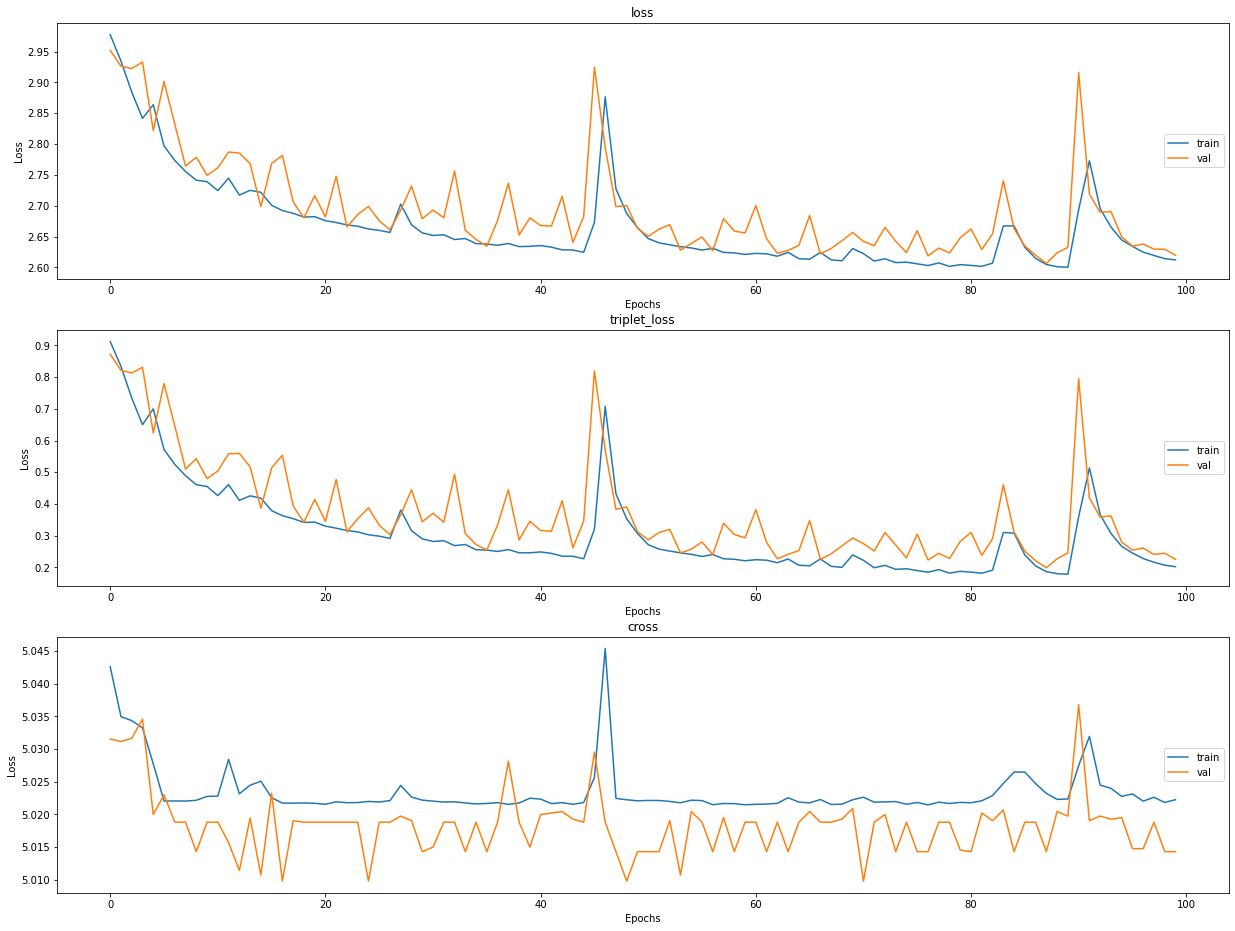

In [14]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

train_loss_history = []
train_loss_triplet_history = []
train_loss__cross_history = []

val_loss_history = []
val_loss_triplet_history = []
val_loss_cross_history = []

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    loss = 0
    train_loss, train_loss_triplet, train_loss_cross = pass_epoch(train_loader, 'Train')  
    val_loss, val_loss_triplet, val_loss_cross = pass_epoch(val_loader, 'Eval') 
    
    train_loss_history.append(train_loss)
    train_loss_triplet_history.append(train_loss_triplet)
    train_loss__cross_history.append(train_loss_cross)

    val_loss_history.append(val_loss)
    val_loss_triplet_history.append(val_loss_triplet)
    val_loss_cross_history.append(val_loss_cross)
    
    trainLoss = [train_loss_history, train_loss_triplet_history, train_loss__cross_history]
    valLoss = [val_loss_history, val_loss_triplet_history, val_loss_cross_history]
    names = ['loss', 'triplet_loss', 'cross']
    show_loss(trainLoss, valLoss, names, False)
#     update_loss_hist(train_loss_history, val_loss_history, False)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'facenet',
        'simsiam': simsiamPath,
        'learning_rate': learning_rate,
        'loss': 'triplet + CrossEntropyLoss',
        'alpha': alpha,
        'state_dict': nn.Sequential(backbone, projector).state_dict(),
    }, is_best=False, filename='./model_V2_1024_fix_addBN/checkpoint_{:04d}.pth.tar'.format(epoch + 1))
# update_loss_hist(train_loss_history, val_loss_history, True)
show_loss(trainLoss, valLoss, names, True)
torch.save(nn.Sequential(backbone, projector), './model_V2_1024_fix_addBN/checkpoint.pth.tar')